# Event Sequence Risk Estimation with NTSB Data

Author: Xinyu Zhao, Arizona State University 

Email: xzhao119@asu.edu

## Part 1: Representing Events through Embedding
This is a demonstration of event embedding to capture intricate relationships between both common and rare event sequences. This enables updating the outcome severity as safety events occur in time.  

## Code Requirements

The Python packages required to run this module are:
- **[```pytorch```]**
    -An open source machine learning framework that accelerates the path from research prototyping to production deployment.
- **[```sklearn```]**
    -Free software machine learning library for the Python programming language.
    
These are in addition to ```pandas```, ```numpy```, and ```matplotlib```.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

## Procedure 1: Loading NTSB Data
### Step 1a: Load Representative Data Group & Investigate Contents

In [2]:
data_group = pd.read_pickle("data/data_group.pkl")
data_group.shape

(62557, 8)

In [3]:
data_group.head()

,ev_id,Aircraft_Key,Occurrence_No,Occurrence_Code,Phase_of_Flight,Subj_Code,damage,ev_highest_injury
0,20001204X00000,1,"[1, 1, 1, 3, 3]","[0, 40, 40, 40, 27, 27, 1]","[0, 20, 20, 20, 34, 34, 1]","[0, 912, 865, 438, 620, 703, 1]","[SUBS, SUBS, SUBS, SUBS, SUBS]","[MINR, MINR, MINR, MINR, MINR]"
1,20001204X00001,1,"[1, 1, 1, 1, 1, 2]","[0, 3, 3, 3, 3, 3, 19, 1]","[0, 32, 32, 32, 32, 32, 3, 1]","[0, 1239, 1316, 63, 692, 692, 1013, 1]","[MINR, MINR, MINR, MINR, MINR, MINR]","[NONE, NONE, NONE, NONE, NONE, NONE]"
2,20001204X00002,1,"[1, 1]","[0, 24, 24, 1]","[0, 3, 3, 1]","[0, 703, 1262, 1]","[SUBS, SUBS]","[NONE, NONE]"
3,20001204X00003,1,"[1, 1, 1, 2]","[0, 52, 52, 52, 55, 1]","[0, 11, 11, 11, 24, 1]","[0, 1263, 692, 1277, 1406, 1]","[SUBS, SUBS, SUBS, SUBS]","[NONE, NONE, NONE, NONE]"
4,20001204X00004,1,"[1, 1, 2, 2]","[0, 52, 52, 55, 55, 1]","[0, 17, 17, 22, 22, 1]","[0, 692, 1277, 503, 1394, 1]","[SUBS, SUBS, SUBS, SUBS]","[NONE, NONE, NONE, NONE]"


### Step 1b: Load Occurrence, Subject, and Phase Reference Numbers

In [4]:
occurrence_code_corpus = np.load("data/occurrence_code_corpus.npy")
subject_code_corpus = np.load("data/subject_code_corpus.npy")
phase_code_corpus = np.load("data/phase_code_corpus.npy")

In [5]:
occurrence_size = len(occurrence_code_corpus)
subject_size = len(subject_code_corpus)
phase_size = len(phase_code_corpus)

In [6]:
print("Number of Occurrence Codes:",occurrence_size)
print(occurrence_code_corpus)
print("Number of Subject Codes:",subject_size)
print(subject_code_corpus)
print("Number of Phase Codes:",phase_size)
print(phase_code_corpus)

Number of Occurrence Codes: 58
['000' '999' '0' '130' '131' '260' '132' '390' '140' '270' '271' '400'
 '150' '280' '410' '160' '290' '420' '170' '171' '300' '172' '430' '180'
 '310' '190' '191' '320' '192' '194' '193' '196' '197' '198' '195' '200'
 '330' '210' '340' '220' '350' '351' '352' '353' '354' '355' '100' '230'
 '231' '232' '360' '110' '240' '370' '120' '250' '380' '']
Number of Subject Codes: 1432
['000' '999' '0' ... '24574' '24575' '']
Number of Phase Codes: 56
['000' '999' '512' '513' '514' '0' '520' '521' '522' '523' '530' '531'
 '310' '540' '541' '542' '550' '551' '552' '553' '560' '561' '562' '563'
 '564' '565' '566' '567' '568' '569' '570' '571' '572' '573' '574' '575'
 '576' '580' '581' '582' '583' '590' '591' '592' '340' '600' '610' '500'
 '501' '502' '503' '504' '505' '510' '511' '']


### Step 1c: Load Event Sequence Data

In [7]:
subj_to_occurrence_dict = pd.read_pickle("data/subj_to_occurrence_dict.pkl")
occurrence_to_subj_dict = pd.read_pickle("data/occurrence_to_subj_dict.pkl")
phase_to_occurrence_dict = pd.read_pickle("data/phase_to_occurrence_dict.pkl")
occurrence_to_phase_dict = pd.read_pickle("data/occurrence_to_phase_dict.pkl")

In [8]:
subj_to_occurrence_dict

{0: [0],
 1: [1],
 2: [41, 55, 47, 5, 39, 40, 28],
 3: [39, 47, 55, 46, 52, 24, 7, 27, 22, 51, 15, 40, 43, 42, 14, 56, 23, 9],
 4: [7, 55, 38, 47],
 5: [5, 27, 55, 26, 35, 38, 15, 47, 52],
 6: [35, 45, 39, 38, 7, 47, 5, 55, 23, 46, 24, 43, 20, 27, 22, 52],
 7: [38, 55, 24, 5, 39, 28, 35, 23, 47, 27, 20, 42, 7, 10],
 8: [27, 24, 55, 47, 35, 15, 9, 22, 16, 46, 56, 10, 39, 13, 38, 20, 5],
 9: [47, 55, 39, 23, 52, 7, 51, 15, 14, 46, 43, 40, 53, 24, 56, 22, 35],
 10: [55,
  38,
  47,
  15,
  39,
  35,
  27,
  23,
  24,
  40,
  56,
  5,
  46,
  12,
  10,
  28,
  22,
  43,
  51,
  7],
 11: [43, 26],
 12: [38, 35, 47, 5, 55, 43, 24, 7, 39, 27],
 13: [24, 38, 55, 39, 27, 15, 5, 20, 47, 44, 22],
 14: [55],
 15: [20, 35, 23, 47, 39],
 16: [55, 15, 39, 5, 47, 38, 27, 24, 35],
 17: [55],
 18: [44, 42, 40, 41, 43, 47, 23, 39],
 19: [55, 5, 47, 39],
 20: [7],
 21: [41],
 22: [42, 35, 44, 3, 43, 40],
 23: [39, 55, 47, 28],
 24: [42, 41, 44, 40],
 25: [40, 43, 41, 44, 42],
 26: [43],
 27: [22, 10, 55, 

## Procedure 2: Train ```RNNModel```, ```SequentialPrediction```, and ```HierarchicalSoftmax```
### Step 2a: Set Up Torch Device
For this demonstration we import ```torch``` and set our device. If no GPU is available, the code will default to using the CPU.


In [21]:
import torch

device = torch.device('cpu')

### Step 2b: Import Pre-Trained ```RNNModel```, ```SequentialPrediction```, and ```HierarchialSoftmax``` models

In [24]:
from util import RNNModel, SequentialPrediction, HierarchicalSoftmax

batch_size=1
embedding_dim = 30  # Embedding of each word
hidden_dim = 30      #Final hidden dimension that is used for prediction
num_layer = 2        # Number of layers 
latent_dim = 30     # Latent dimension 

lstm_model =  RNNModel(phase_size, occurrence_size, subject_size, embedding_dim, latent_dim, num_layer, batch_size, hidden_dim, device).to(device)
hierarchical_tree1 = HierarchicalSoftmax(hidden_dim, phase_to_occurrence_dict, occurrence_to_subj_dict,subj_to_occurrence_dict,device).to(device)
hierarchical_tree1.load_state_dict(torch.load('model/hierarchical_softmax_rnn_20200801_1227_rnn__19.sav',map_location=torch.device('cpu')))
lstm_model.load_state_dict(torch.load('model/model_rnn_20200801_1227_rnn__19.sav',map_location=torch.device('cpu')))

<All keys matched successfully>

In [25]:
markovian_model = SequentialPrediction(phase_size,occurrence_size,subject_size, embedding_dim, batch_size,hidden_dim, device)
hierarchical_tree2 = HierarchicalSoftmax(hidden_dim, phase_to_occurrence_dict, occurrence_to_subj_dict,subj_to_occurrence_dict,device).to(device)
hierarchical_tree2.load_state_dict(torch.load('model/hierarchical_softmax_sequential_20200801_1226_nornn__19.sav',map_location=torch.device('cpu')))
markovian_model.load_state_dict(torch.load('model/model_sequential_20200801_1226_nornn__19.sav',map_location=torch.device('cpu')))

<All keys matched successfully>

# Visualize phase embedding 

In [26]:
phases = ['STANDING', 'TAXI', 'TAKEOFF', 'CLIMB', 'CRUISE', 'DESCENT', 'APPROACH', 'LANDING', 'MANEUVERING', 'HOVER']
marker_list = [".", "v", "8", "x", "s", "H",",", "^", "<", ">"]
phase_code_corpus[phase_code_corpus=='']=111
phase_list = np.array([int(x) for x in phase_code_corpus])
phase_index = {}
phase_index['STANDING'] = (phase_list>=500)&(phase_list<=505)
phase_index['TAXI'] = (phase_list>=510)&(phase_list<=514)
phase_index['TAKEOFF'] = (phase_list>=520)&(phase_list<=523)
phase_index['CLIMB'] = (phase_list>=530)&(phase_list<=531)
phase_index['CRUISE'] = (phase_list>=540)&(phase_list<=541)
phase_index['DESCENT'] = (phase_list>=550)&(phase_list<=553)
phase_index['APPROACH'] = (phase_list>=560)&(phase_list<=569)
phase_index['LANDING'] = (phase_list>=570)&(phase_list<=576)
phase_index['MANEUVERING'] = (phase_list>=580)&(phase_list<=583)
phase_index['HOVER'] = (phase_list>=590)&(phase_list<=592)

In [31]:
word_vectors = lstm_model.word_embedding_phase.weight.cpu().detach().numpy()
word_vectors.shape 
word_vectors

array([[ 7.6813084e-01,  4.0779155e-01,  4.5363802e-01, ...,
        -5.3213853e-01, -3.7035432e-01,  2.8820619e-01],
       [-3.5565467e-05, -3.1247164e-05, -4.3784017e-05, ...,
        -7.4328796e-05, -4.9127051e-05,  5.5807421e-05],
       [ 2.3661651e-01,  2.4452163e-01,  1.7259872e-01, ...,
         4.6918052e-01,  5.1536840e-01,  9.5451407e-02],
       ...,
       [ 6.3184762e-01,  1.2794448e-01, -1.5286161e-01, ...,
         3.2621998e-01, -2.5320964e-02, -5.3941822e-01],
       [-6.6880447e-01, -2.7205947e-01, -7.0543891e-01, ...,
         4.1217264e-02,  1.9191974e-01,  1.4594999e-01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

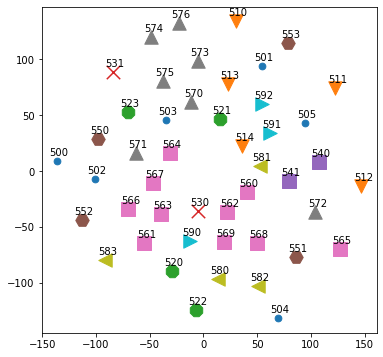

<Figure size 432x288 with 0 Axes>

In [32]:
from sklearn.manifold import TSNE

model_tsne = TSNE(n_components = 2, perplexity=23, early_exaggeration=1,learning_rate=200, n_iter=10000, random_state=0)
tsne_data = model_tsne.fit_transform(word_vectors)
NUM_PHASES = len(phases)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
for i in range(NUM_PHASES):
    index = phase_index[phases[i]]
    ax.scatter(tsne_data[index,0], tsne_data[index,1], marker=marker_list[i], s=180)
    for word, (x,y) in zip(phase_code_corpus[index], tsne_data[index]):
        ax.text(x-7, y+5 , word)
plt.show()
plt.tight_layout()

# Visualize occurrence embedding 

In [33]:
occurrences = ['MALFUNCTION', 'FIRE/EXPLOSION', 'GEAR', 'LOSS OF ENGINE POWER', 'ON GROUND/WATER COLLISION', 'IN FLIGHT COLLISION', 'LOSS OF CONTROL', 'MIDAIR COLLISION', 'NOSE', 'PROPELLER']
marker_list = [".", "v", "8", "x", "s", "H",",", "^", "<", ">"]
occurrence_code_corpus[occurrence_code_corpus=='']=111
occurrence_list = np.array([int(x) for x in occurrence_code_corpus])
occurrence_index = {}
occurrence_index['MALFUNCTION'] = (occurrence_list>=130)&(occurrence_list<=132)
occurrence_index['FIRE/EXPLOSION'] = (occurrence_list>=170)&(occurrence_list<=172)
occurrence_index['GEAR'] = (occurrence_list>=190)&(occurrence_list<=198)
occurrence_index['LOSS OF ENGINE POWER'] = (occurrence_list>=350)&(occurrence_list<=353)
occurrence_index['ON GROUND/WATER COLLISION'] = (occurrence_list>=310)&(occurrence_list<=330)
occurrence_index['IN FLIGHT COLLISION'] = (occurrence_list>=220)&(occurrence_list<=232)
occurrence_index['LOSS OF CONTROL'] = (occurrence_list>=250)&(occurrence_list<=260)
occurrence_index['MIDAIR COLLISION'] = (occurrence_list>=270)&(occurrence_list<=271)
occurrence_index['NOSE'] = (occurrence_list>=290)&(occurrence_list<=300)
occurrence_index['PROPELLER'] = (occurrence_list>=360)&(occurrence_list<=370)

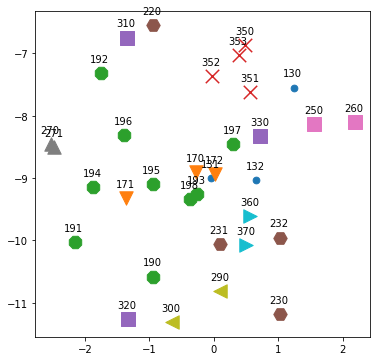

<Figure size 432x288 with 0 Axes>

In [35]:
word_vectors = lstm_model.word_embedding_occurrence.weight.cpu().detach().numpy()
model_tsne = TSNE(n_components = 2, perplexity=23, early_exaggeration=1,learning_rate=200, n_iter=10000, random_state=0)
tsne_data = model_tsne.fit_transform(word_vectors)
NUM_OCCUR = 10
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
for i in range(NUM_OCCUR):
    index = occurrence_index[occurrences[i]]
    ax.scatter(tsne_data[index,0], tsne_data[index,1], marker=marker_list[i], s=180)
    for word, (x,y) in zip(occurrence_code_corpus[index], tsne_data[index]):
        ax.text(x-0.16, y+0.18 , word)
plt.show()
plt.tight_layout()